# Galaxy life evolution simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

Generate a squared lattice which stands for the galaxy: each cell is a planet. The habitable zone can be approximated like a circular crown centered in the galaxy center. Its radius depends on many factors, like metallic abundancy and star formation rate.

<img src="images/GHZ.png">

###galaxy time (maybe can be implemented)### 

0 stands for habitable, -1 for less habitable (maybe disable this feature), -2 for no habitable

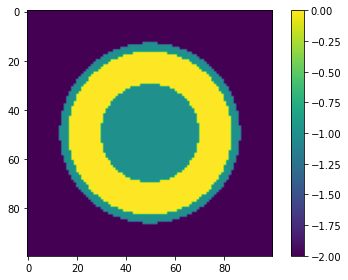

In [25]:
L = 100 # Square lattice dimension 

# Milky Way has an about 15 kpc radius and its habitable zone has radii about 7 and 9 kpc. Convert
inner_r_MW = 6.
outer_r_MW = 10.

inner_r = inner_r_MW * L/float(2 * 15)
outer_r = outer_r_MW * L/float(2 *15)
large_outer_r= (outer_r_MW + 1) * L/float(30) # Maybe needed, maybe not

galaxy = np.ones((L, L)) * (-2)
for i in range(L):
    for j in range(L):
        r2 = (i - 49.5) **2 + (j - 49.5) **2
        if r2 >= inner_r**2 and r2 <= outer_r**2:
            galaxy[i][j] = 0
        elif r2 < large_outer_r**2:
            galaxy[i][j] = -1    
fig, ax = plt.subplots()
fig.tight_layout()
im = ax.imshow(X=galaxy)
cbar = ax.figure.colorbar(im, ax=ax)

We say that life can emerge only from a 0, and can be present in 3 stages
- 1 if microscopic;
- 2 for intelligent life;
- 3 for galaxy-colonization ready.

Evolution normally brings a stage to the next one, but two other events can be present:
- Catastrophic event, which can bring a stage to a lower one or wipe out civilization;
- Colonization: a planet can be colonized by some near neighbour (still tune this).


All three of these events can bring a stage in [0,1,2,3] to any other with a certain characteristic time and probability.

In [26]:
# Characteristic times - fixed (EVOLUTION)
t01 = 600
t12 = 120
t23 = 20

# Characteristic times - to play with (CATASTROPHIC EVENT)
t10 = 100

t20 = 100
t21 = 100

t30 = 200
t31 = 120
t32 = 40

# Characteristic times - to play with (COLONIZATION)
t03 = 10
t13 = 10
t23_colonization = 10

# Probabilities - fixed (EVOLUTION)
A01 = 0.003
A12 = 0.003
A23 = 0.003

# Probabilities - to play with (COLONIZATION)
A03 = 0.5
A13 = 1
A23_colonization = 1

# Probabilities - to play with (CATASTROPHIC EVENT)
A10 = 0.005

A20 = 0.005
A21 = 0.05

A30 = 0.5
A31 = 0.5
A32 = 0.5

To have a look at the evolution of the galaxy we define two other variables:
- clock, which tells us how much "time" a certain cell stays in that stage
- world_map, which tells us how old a certain civilization is and where is located

In [27]:
# For each cell, we want to measure how long it has been since something changed
clock = np.zeros((L,L))
world_map = np.copy(galaxy)

Then we will also need a function to check if a certain 3-stage civilization has neighbour to colonize.


###Maybe we can try different options on how the choice is made and how far they can go###

In [28]:
def check_neighbors(galaxy, i, j):
    N = galaxy.shape[0] # Lattice dimension
# set accumulators
    number_of_planets = 0 
    number_of_neighbors = 0
    neighbor_planets = []
    
    # Check NN
    for k in [i - 1, i, i + 1]:
        for l in [j - 1, j, j + 1]:
            if k < 0 or k >= N or l < 0 or l >= N: # OBC + errors check
                continue
            if galaxy[k][l] == -1 or galaxy[k][l] == -2: # Let both be surely not inhabitable? Try different options
                continue
            if k == i and l == j:
                continue
            else:
                # Accumulate values
                number_of_planets += 1
                if galaxy[k][l] == 3:
                    number_of_neighbors += 1
                    neighbor_planets.append((k, l))
    # Choose one NN random if there is one                
    if number_of_neighbors >= 1:
        index = np.random.randint(number_of_neighbors)
        selected_neighbor = neighbor_planets[index]
    else:
        selected_neighbor = None
    return number_of_planets, number_of_neighbors, selected_neighbor

In [41]:
# SIMULATION
civilization_number = 0
Nstep = 1500 # number of time steps, needs to understand how to convert in plausible units

for step in range(Nstep):
    if step % 200 == 0: # print to check how long It takes
        print("Simulation reached", (step // 200), "billion(?) years.")
    # We make a copy of our galaxy's state so that we don't mess it up
    new_galaxy = np.copy(galaxy)
    # We go cell by cell to see what happens there - Maybe smarter way to do this
    for i in range(49 - int(outer_r), 50 + int(outer_r) + 1):
        for j in range(50 - int(outer_r), 50 + int(outer_r) + 1):
            # Check if outside the Galactic Habitable Zone
            r2 = (i - 49.5) * (i - 49.5) + (j - 49.5) * (j - 49.5)
            if r2 < inner_r**2 or r2 > outer_r**2:
                # It is outside - we skip this cell
                continue
            planets, neighbors, chosen_neighbor = check_neighbors(new_galaxy, i, j)

            if galaxy[i][j] == 0: # NO LIFE ON THIS PLANET
                p1 = A01 * clock[i][j] / t01  # come by evolution
                p2 = 0
                p3 = (A03 * clock[i][j] / t03) * (neighbors / planets)  # or by colonization

                # Normalize
                p_sum = p1 + p2 + p3
                if p_sum > 1:
                    p1 = p1 / p_sum
                    p2 = p2 / p_sum
                    p3 = p3 / p_sum
                p0 = 1.0 - p_sum

                # Generate a random number to see which of these events happen
                rnd = np.random.random()
                if rnd < p0: # Nothing happens
                    clock[i][j] += 1
                elif rnd < p0 + p1: # Evolution happens
                    new_galaxy[i][j] = 1
                    clock[i][j] = 0
                else: 
                    new_galaxy[i][j] = 3 # Colonization happens
                    clock[i][j] = 0
                    k, l = chosen_neighbor
                    world_map[i][j] = world_map[k][l]
                    
                    
                    
            elif galaxy[i][j] == 1: # SIMPLE LIFE ON THIS PLANET (BACTERIA)
                p0 = A10 * clock[i][j] / t10  # catastrophe
                p2 = A12 * clock[i][j] / t12  # evolution
                p3 = (A13 * clock[i][j] / t13) * (neighbors / planets)  # colonization

                # Normalize
                p_sum = p0 + p2 + p3
                if p_sum > 1:
                    p0 = p0 / p_sum
                    p2 = p2 / p_sum
                    p3 = p3 / p_sum
                p1 = 1.0 - p_sum

                
                # Generate a random number to see which of these events happen
                rnd = np.random.random()
                if rnd < p0: # Wipe out
                    new_galaxy[i][j] = 0
                    clock[i][j] = 0
                elif rnd < p0 + p1: # Nothing happens
                    clock[i][j] += 1
                elif rnd < p0 + p1 + p2: # Evolution happens
                    new_galaxy[i][j] = 2
                    clock[i][j] = 0
                else:
                    new_galaxy[i][j] = 3 # Colonization happens
                    clock[i][j] = 0
                    k, l = chosen_neighbor
                    world_map[i][j] = world_map[k][l]
                    
                    
                    
                    
                    
            elif galaxy[i][j] == 2: # COMPLEX LIFE ON THIS PLANET (PLANTS, ANIMALS, PRIMITIVES)
                p0 = A20 * clock[i][j] / t20  # wipe out
                p1 = A21 * clock[i][j] / t21  # minor catastrophe
                p3_colonization = (
                    A23_colonization * clock[i][j] / t23_colonization
                ) * (
                    neighbors / planets
                )  # colonization
                p3_evolution = A23 * clock[i][j] / t23  # evolution

                
                # Normalization
                p_sum = p0 + p1 + p3_colonization + p3_evolution
                if p_sum > 1:
                    p0 = p0 / p_sum
                    p1 = p1 / p_sum
                    p3_colonization = p3_colonization / p_sum
                    p3_evolution = p3_evolution / p_sum
                p2 = 1.0 - p_sum

                # Generate a random number to see which of these events happen 
                rnd = np.random.random()
                if rnd < p0: # Wipe out
                    new_galaxy[i][j] = 0
                    clock[i][j] = 0
                elif rnd < p0 + p1: # Minor catastrophe
                    new_galaxy[i][j] = 1
                    clock[i][j] = 0
                elif rnd < p0 + p1 + p2: # Nothing happens
                    clock[i][j] += 1
                elif rnd < p0 + p1 + p2 + p3_colonization: # Colonization
                    new_galaxy[i][j] = 3
                    clock[i][j] = 0
                    k, l = chosen_neighbor
                    world_map[i][j] = world_map[k][l]
                else: # Evolution 
                    new_galaxy[i][j] = 3
                    clock[i][j] = 0
                    civilization_number += 1
                    world_map[i][j] = civilization_number

                    
            elif new_galaxy[i][j] == 3: # TECHNOLOGICALLY ADVANCED CIVILIZATION
                p0 = A30 * clock[i][j] / t30  # wipe out
                p1 = A31 * clock[i][j] / t31  # major catastrophe
                p2 = A32 * clock[i][j] / t32  # minor catastrophe

                # Normalization
                p_sum = p0 + p1 + p2
                if p_sum > 1:
                    p0 = p0 / p_sum
                    p1 = p1 / p_sum
                    p2 = p2 / p_sum
                p3 = 1.0 - p_sum

                
                # Generate a random number to see which of these events happen
                rnd = np.random.random()
                if rnd < p0: # Wipe out
                    new_galaxy[i][j] = 0
                    clock[i][j] = 0
                    world_map[i][j] = 0
                elif rnd < p0 + p1: # Major catastrophe
                    new_galaxy[i][j] = 1
                    clock[i][j] = 0
                    world_map[i][j] = 0
                elif rnd < p0 + p1 + p2: # Minor catastrophe
                    new_galaxy[i][j] = 2
                    clock[i][j] = 0
                    world_map[i][j] = 0
                else: # Nothing happens
                    clock[i][j] += 1
    galaxy = np.copy(new_galaxy) # Only here we change our galaxy
print("Simulation finished at {} billion years".format(round(float(Nstep)/200)))

Simulation reached 0 billion(?) years.
Simulation reached 1 billion(?) years.
Simulation reached 2 billion(?) years.
Simulation reached 3 billion(?) years.
Simulation reached 4 billion(?) years.
Simulation reached 5 billion(?) years.
Simulation reached 6 billion(?) years.
Simulation reached 7 billion(?) years.
Simulation finished at 8 billion years


Finally, we can see the galaxy life evolution

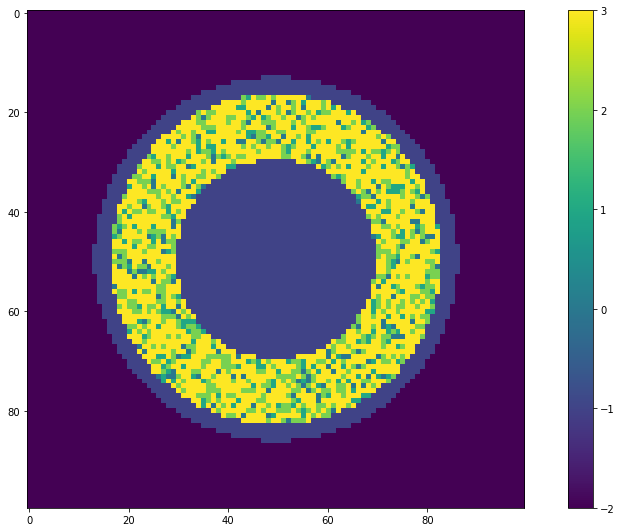

In [46]:
plt.rcParams["figure.figsize"] = [12.50, 7.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
fig.tight_layout()
im = ax.imshow(X=galaxy)
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()

And the "world map", which gives us a political view of the civilizations in the galaxy

C:\Users\39339\AppData\Local\Temp/ipykernel_6464/1603810112.py:18: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = ax.figure.colorbar(im, ax=ax, cmap=colormap)


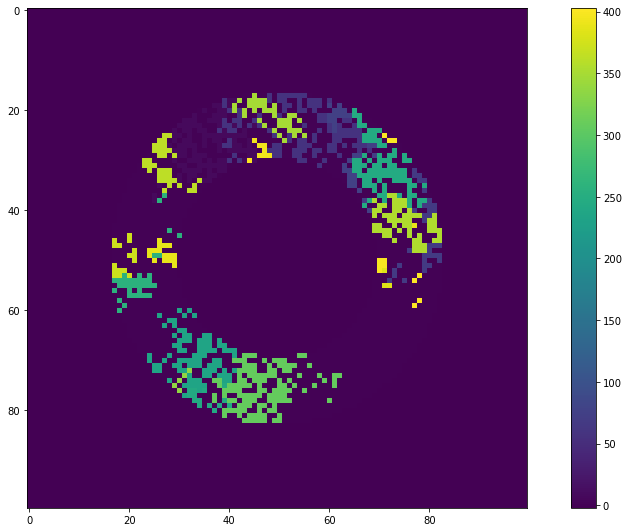

In [53]:
plt.rcParams["figure.figsize"] = [12.50, 7.50]
plt.rcParams["figure.autolayout"] = True

# All of this to change color?
colormap = plt.cm.get_cmap('plasma') # 'plasma' or 'viridis'
#colors = colormap(scaled_z)
#sc = plt.scatter(x, y, c=colors)
#sm = plt.cm.ScalarMappable(cmap=colormap)
#sm.set_clim(vmin=0, vmax=100)
#plt.colorbar(sm)
#plt.xlabel("Actual")
#plt.ylabel("Predicted")
#plt.show()

fig, ax = plt.subplots()
fig.tight_layout()
im = ax.imshow(X=world_map)
cbar = ax.figure.colorbar(im, ax=ax, cmap=colormap)
plt.show()